In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'C:\Users\HP\Desktop\Data Science\Data Sets For Practice\student_clustering.csv')
df.head()

,cgpa,iq
0,5.13,88
1,5.90,113
2,8.36,93
3,8.27,97
4,5.45,110


In [3]:
df.shape

(200, 2)

# Implementation for computing Hopkins' Statistic:


* A value for Hopkins' Statistic higher than 0.75 indicates a clustering tendency at the 90% confidence level.


* We can interpret Hopkins' statistic in the following manner:


* If the value is between {0.01, ...,0.3}, the data is regularly spaced.


* If the value is around 0.5, it is random.


* If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [4]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np

# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X):
    
    X=X.values  #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures
    
    
    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))
    
    
    
    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]
   
    
    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=1)
    nbrs=neigh.fit(X)
    
    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour
    
    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]
    
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H

In [5]:
hopkins_statistic(df)

0.9642206684349507

In [6]:
l = [] #list to hold values for each call
for i in range(20):
    H=hopkins_statistic(df)
    l.append(H)
#print average value:
np.mean(l)

0.9192759342637119

# Model Building

In [7]:
from sklearn.cluster import KMeans

In [8]:
kmeans = KMeans(n_clusters=5,max_iter=100)
kmeans.fit(df)

KMeans(max_iter=100, n_clusters=5)

In [9]:
kmeans.labels_

array([2, 1, 4, 0, 1, 1, 0, 3, 1, 4, 2, 1, 0, 2, 1, 0, 1, 4, 1, 1, 0, 2,
       4, 2, 2, 0, 2, 3, 4, 1, 3, 1, 3, 1, 0, 0, 3, 1, 2, 1, 2, 0, 4, 2,
       3, 3, 4, 1, 3, 1, 2, 2, 3, 0, 3, 1, 1, 3, 1, 3, 1, 0, 0, 3, 2, 3,
       4, 2, 1, 0, 1, 3, 4, 2, 1, 3, 1, 3, 2, 4, 4, 3, 1, 2, 3, 2, 3, 1,
       3, 1, 3, 3, 4, 2, 0, 4, 3, 0, 4, 3, 1, 2, 2, 3, 2, 2, 4, 2, 3, 3,
       4, 3, 1, 1, 4, 3, 0, 1, 3, 2, 2, 1, 4, 3, 0, 2, 0, 1, 2, 0, 4, 1,
       2, 2, 1, 3, 1, 2, 0, 0, 4, 2, 1, 2, 2, 3, 2, 3, 1, 2, 3, 2, 3, 3,
       2, 0, 1, 3, 1, 4, 2, 3, 1, 4, 3, 2, 1, 2, 2, 3, 3, 1, 3, 2, 2, 0,
       3, 1, 2, 3, 3, 1, 1, 1, 0, 2, 4, 4, 3, 1, 4, 4, 2, 2, 0, 2, 3, 1,
       1, 3])

# Finding the optimal number of cluster using Elbow Curve


* We can find the elbow point by seeing the graph to select the number of clusters of our dataset.


* Where the curve is stabalize is called elbow point.

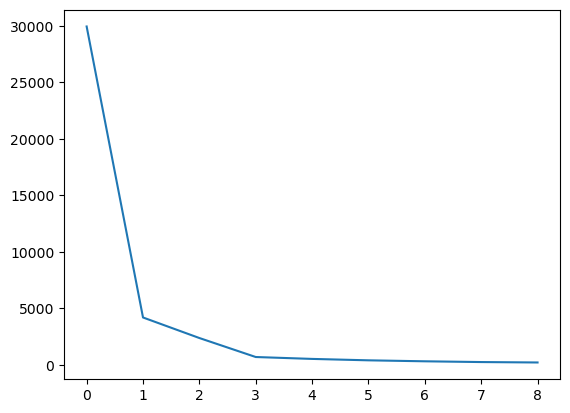

In [10]:
wcss = []
range_n_clusters = [1,2,3,4,5,6,7,8,9]
for i in range_n_clusters:
    km = KMeans(n_clusters=i)
    km.fit_predict(df)
    wcss.append(km.inertia_)
    
plt.plot(wcss)

### as we see 3 clusters are best for our dataset 

# Silhouette Analysis

* Silhouette analysis is a method for evaluating the quality of clustering results. It provides a way to quantify how well each data point fits into its assigned cluster and how separated the clusters are from each other. The technique produces a silhouette score for each data point, which is a measure of how similar that point is to its own cluster compared to other clusters. The silhouette score ranges from -1 to +1, with higher values indicating better clustering.


* In silhouette analysis, each data point is first assigned to a cluster based on a clustering algorithm. Then, the silhouette score is calculated for each data point as follows:


* Compute the average distance between the data point and all other points in the same cluster. This is denoted as a(i).


* Compute the average distance between the data point and all points in the nearest cluster (i.e., the cluster that the data point is not a part of). This is denoted as b(i).


* Compute the silhouette score as (b(i) - a(i)) / max(a(i), b(i)).

In [11]:
from sklearn.metrics import silhouette_score

# Range of number of clusters to try
range_n_clusters = range(2, 11)

# Compute silhouette scores
silhouette_scores = []
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=123)
    cluster_labels = clusterer.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg:.3f}")

For n_clusters = 2, the average silhouette score is 0.754
For n_clusters = 3, the average silhouette score is 0.711
For n_clusters = 4, the average silhouette score is 0.735
For n_clusters = 5, the average silhouette score is 0.692
For n_clusters = 6, the average silhouette score is 0.646
For n_clusters = 7, the average silhouette score is 0.615
For n_clusters = 8, the average silhouette score is 0.553
For n_clusters = 9, the average silhouette score is 0.552
For n_clusters = 10, the average silhouette score is 0.544


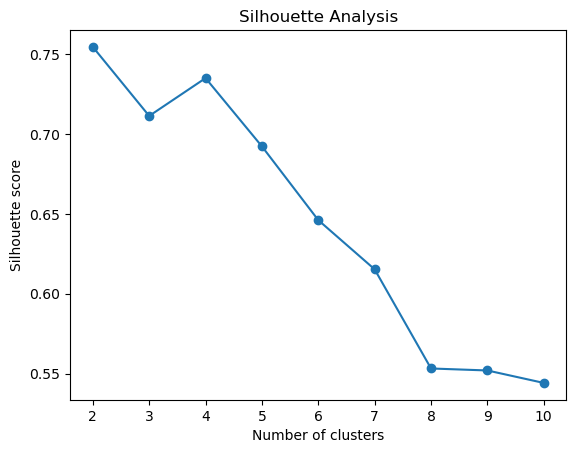

In [12]:
# Plot silhouette scores as a line plot
plt.plot(range_n_clusters, silhouette_scores, '-o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("Silhouette Analysis")
plt.show()

## Max Silhouette Score as k = 2, Hence 2 Clusters is the right option but we check again with the help of cluster visualization.

# Visualization of Clusters (K=2)

* It is a technique by which we visualize the quality of clusters.

In [13]:
kmeans = KMeans(n_clusters=2,max_iter=100)
kmeans.fit(df)
clusters=kmeans.labels_

Text(0.5, 1.0, 'PCA Plot of Clusters')

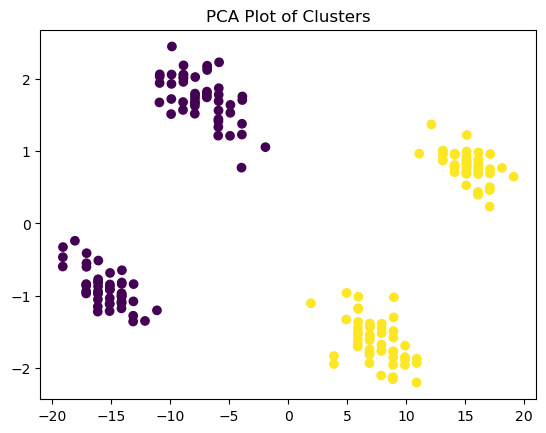

In [14]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df)

# Create a scatter plot of the clusters
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters)
plt.title("PCA Plot of Clusters")

In [15]:
df_pca

array([[-14.09230217,  -0.8379357 ],
       [ 10.89803234,  -1.87527909],
       [ -8.87210708,   2.02256483],
       [ -4.88904944,   1.64394651],
       [  7.87336871,  -2.10746427],
       [  6.90703123,  -1.60637358],
       [ -3.88155037,   1.71136767],
       [ 13.1022294 ,   0.87272297],
       [  7.89792124,  -1.76835194],
       [ -7.89421547,   1.68105642],
       [-16.12535365,  -1.22212534],
       [  7.92030738,  -1.45916128],
       [ -4.89699291,   1.53423369],
       [-14.1016899 ,  -0.9675963 ],
       [  5.89736576,  -1.70371643],
       [ -6.88093933,   1.82826872],
       [  8.87436859,  -2.12980813],
       [-10.90227003,   1.67827076],
       [  8.91408592,  -1.58124407],
       [ 10.89369954,  -1.93512245],
       [ -3.94943089,   0.77382182],
       [-16.10657818,  -0.96280414],
       [ -9.91138002,   1.51629241],
       [-15.11496604,  -1.1148086 ],
       [-14.10457843,  -1.00749187],
       [ -3.91621276,   1.23262085],
       [-15.10918897,  -1.03501746],
 

PCA : Principal Component Analysis, it will reduce the dimension of data set to 2d or 3d. It is not possible to plot all the features of dataset in a single graph. So, we use PCA to reduce the dimension then we will see the whole dataset or datapoints in a single graph.

# Visualization of Clusters (K=3)

In [16]:
kmeans = KMeans(n_clusters=3,max_iter=100)
kmeans.fit(df)
cluster=kmeans.labels_

Text(0.5, 1.0, 'PCA Plot of Clusters')

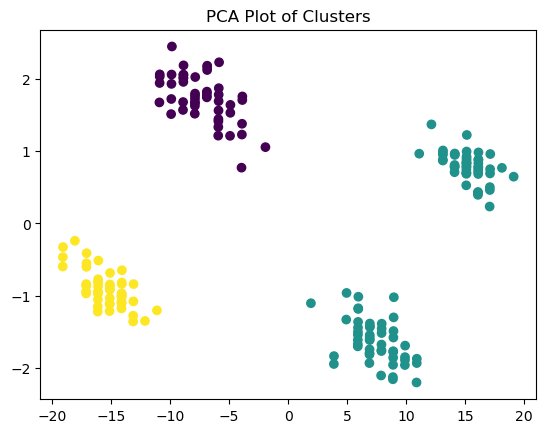

In [17]:
# Create a scatter plot of the clusters
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=cluster)
plt.title("PCA Plot of Clusters")

# Visualization of Clusters (K=4)

In [18]:
kmeans = KMeans(n_clusters=4,max_iter=100)
kmeans.fit(df)
cluster=kmeans.labels_

Text(0.5, 1.0, 'PCA Plot of Clusters')

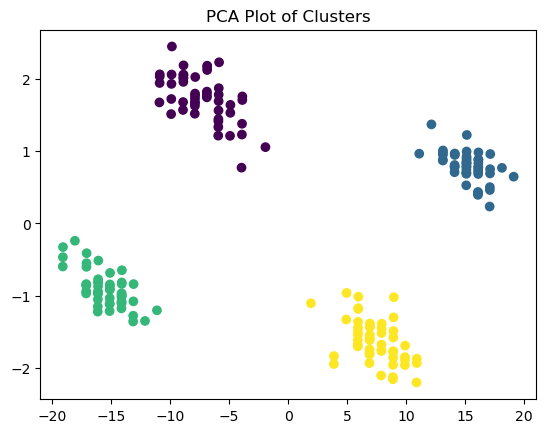

In [19]:
# Create a scatter plot of the clusters
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=cluster)
plt.title("PCA Plot of Clusters")

## As we see if we make 4 clusters then it is the right option.

In [20]:
kmeans = KMeans(n_clusters=4,max_iter=100)
kmeans.fit(df)
kmeans.labels_

array([0, 1, 2, 2, 1, 1, 2, 3, 1, 2, 0, 1, 2, 0, 1, 2, 1, 2, 1, 1, 2, 0,
       2, 0, 0, 2, 0, 3, 2, 1, 3, 1, 3, 1, 2, 2, 3, 1, 0, 1, 0, 2, 2, 0,
       3, 3, 2, 1, 3, 1, 0, 0, 3, 2, 3, 1, 1, 3, 1, 3, 1, 2, 2, 3, 0, 3,
       2, 0, 1, 2, 1, 3, 2, 0, 1, 3, 1, 3, 0, 2, 2, 3, 1, 0, 3, 0, 3, 1,
       3, 1, 3, 3, 2, 0, 2, 2, 3, 2, 0, 3, 1, 0, 0, 3, 0, 0, 2, 0, 3, 3,
       2, 3, 1, 1, 2, 3, 2, 1, 3, 0, 0, 1, 2, 3, 2, 0, 2, 1, 0, 2, 2, 1,
       0, 0, 1, 3, 1, 0, 2, 2, 2, 0, 1, 0, 0, 3, 0, 3, 1, 0, 3, 0, 3, 3,
       0, 2, 1, 3, 1, 2, 0, 3, 1, 2, 3, 0, 1, 0, 0, 3, 3, 1, 3, 0, 0, 2,
       3, 1, 0, 3, 3, 1, 1, 1, 2, 0, 2, 2, 3, 1, 2, 2, 0, 0, 2, 0, 3, 1,
       1, 3])

In [21]:
# Assigning these label to dataset

df['Cluster_ID'] = kmeans.labels_
df.head()

,cgpa,iq,Cluster_ID
0,5.13,88,0
1,5.90,113,1
2,8.36,93,2
3,8.27,97,2
4,5.45,110,1


# Visualization of Data with respect to Cluster_ID 

<AxesSubplot:xlabel='Cluster_ID', ylabel='iq'>

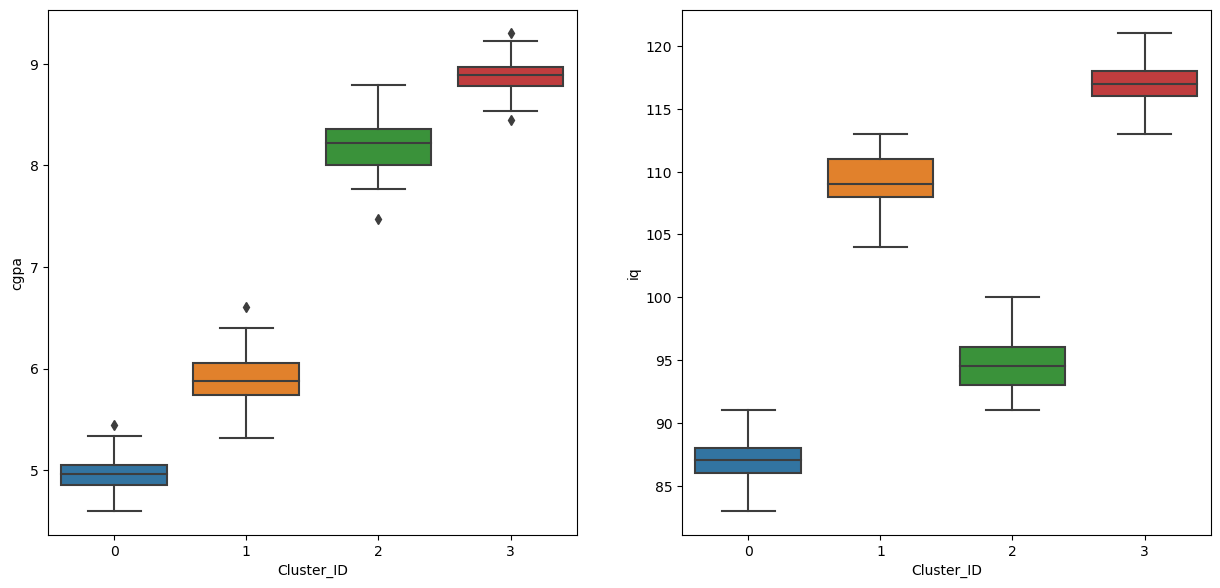

In [22]:
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
sns.boxplot(x='Cluster_ID',y='cgpa',data=df)
plt.subplot(2,2,2)
sns.boxplot(x='Cluster_ID',y='iq',data=df)

# HIERARCHICAL CLUSTERING

In [23]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

* Linkage : It is a parameter in Agglomerative Clustering to select the type of Agglomerative Clustering.


* There are 4 types of Agglomerative Clustering / Linkage Parameter :-


* 1) Min (single)


* 2) Max (complete)


* 3) Average


* 4) Ward

## 1) Single Linkage

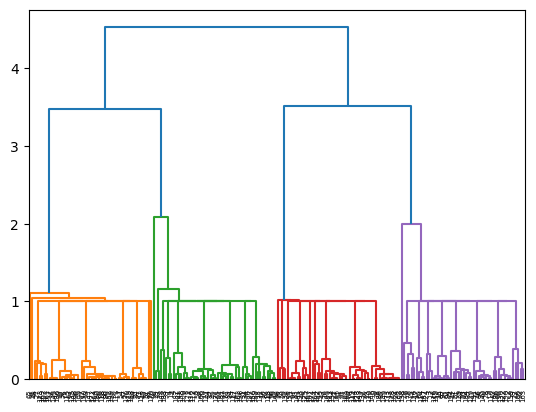

In [24]:
# single linkage 

mergings = linkage(df, method = 'single', metric = 'euclidean')
dendrogram(mergings)
plt.show()

In [25]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='single')
labels_=cluster.fit_predict(df)

Text(0.5, 1.0, 'PCA Plot of Clusters')

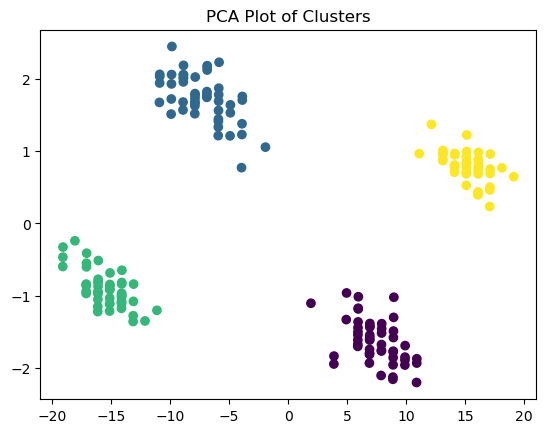

In [26]:
# Create a scatter plot of the clusters
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels_)
plt.title("PCA Plot of Clusters")

## 2) Complete Linkage

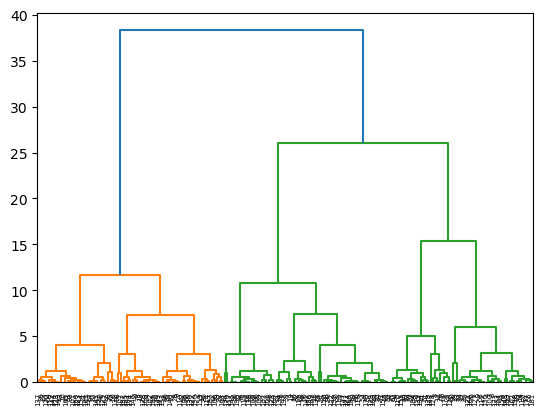

In [27]:
# complete linkage 

mergings = linkage(df, method = 'complete', metric = 'euclidean')
dendrogram(mergings)
plt.show()

In [28]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
labels=cluster.fit_predict(df)

Text(0.5, 1.0, 'PCA Plot of Clusters')

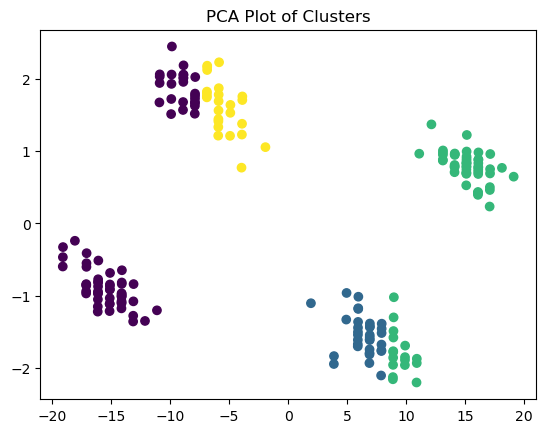

In [29]:
# Create a scatter plot of the clusters
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels)
plt.title("PCA Plot of Clusters")

## 3) Average Linkage

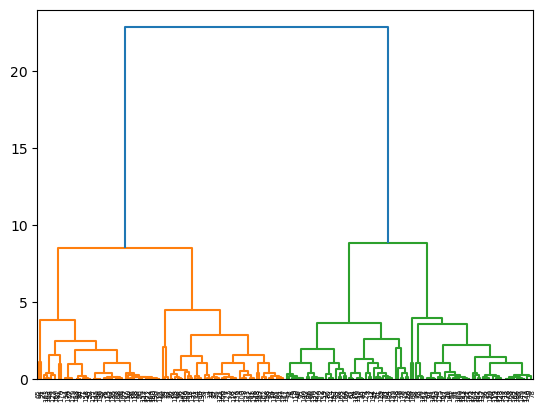

In [30]:
# complete linkage 

mergings = linkage(df, method = 'average', metric = 'euclidean')
dendrogram(mergings)
plt.show()

In [31]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')
labels_=cluster.fit_predict(df)

Text(0.5, 1.0, 'PCA Plot of Clusters')

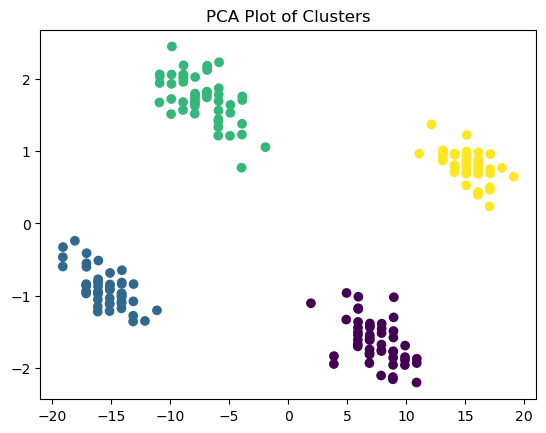

In [32]:
# Create a scatter plot of the clusters
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels_)
plt.title("PCA Plot of Clusters")

## 4)Ward Linkage

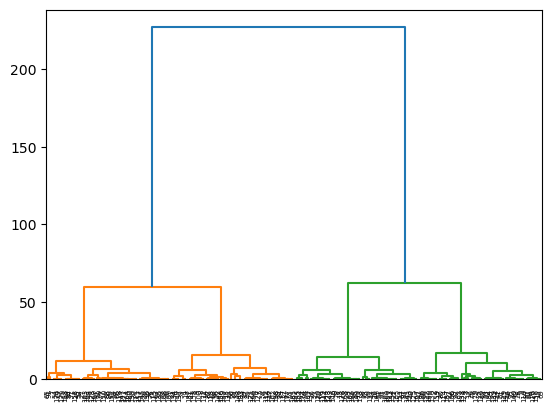

In [33]:
# complete linkage 

mergings = linkage(df, method = 'ward', metric = 'euclidean')
dendrogram(mergings)
plt.show()

In [34]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
labels_=cluster.fit_predict(df)

Text(0.5, 1.0, 'PCA Plot of Clusters')

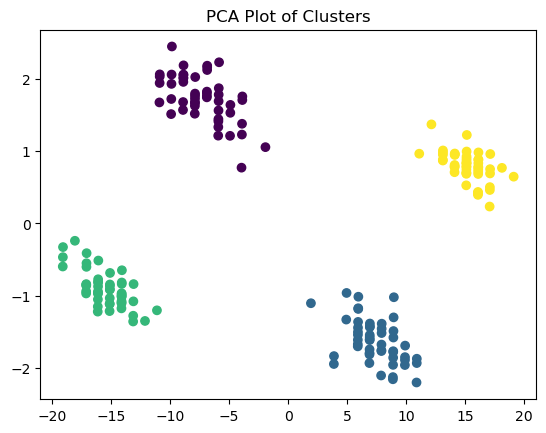

In [35]:
# Create a scatter plot of the clusters
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels_)
plt.title("PCA Plot of Clusters")

# We see that K-Mean Clustering and Hierarchical Clustering both are best to form clusters in this dataset. So, We choose any of them.

In [36]:
# Assigning these label to dataset

df['cluster_labels'] = labels_
df.head()

,cgpa,iq,Cluster_ID,cluster_labels
0,5.13,88,0,2
1,5.90,113,1,1
2,8.36,93,2,0
3,8.27,97,2,0
4,5.45,110,1,1


# Visualization of Data with respect to cluster_labels 

<AxesSubplot:xlabel='cluster_labels', ylabel='iq'>

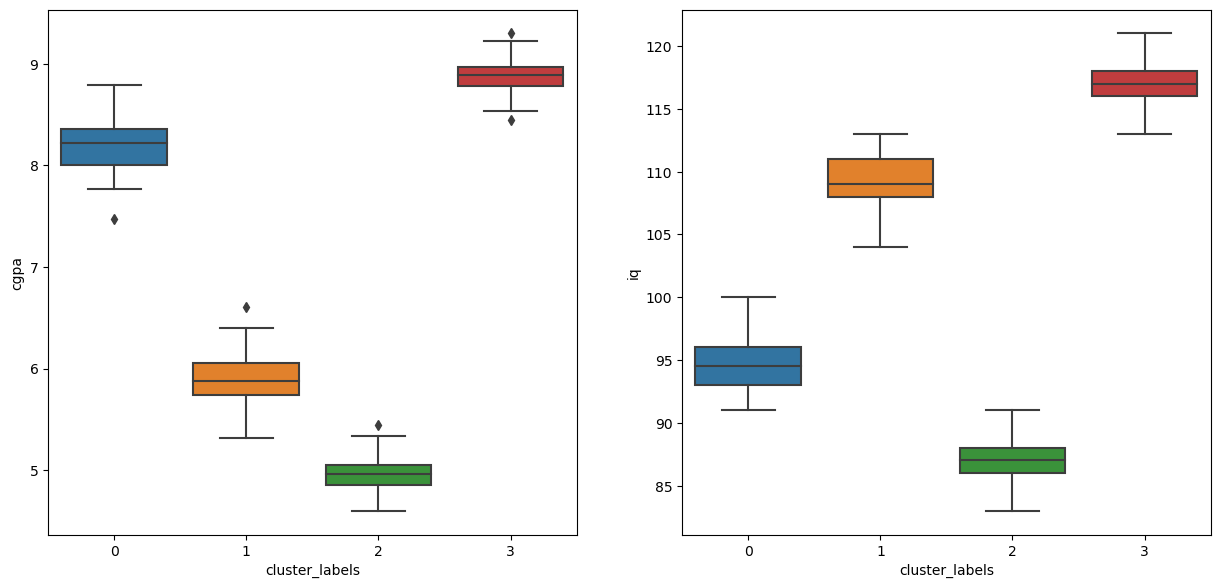

In [37]:
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
sns.boxplot(x='cluster_labels',y='cgpa',data=df)
plt.subplot(2,2,2)
sns.boxplot(x='cluster_labels',y='iq',data=df)